In [1]:
import json
import re
from copy import deepcopy

import joblib
import numpy as np
import pandas as pd
import plotly
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
with open('../dataset/goodreads_reviews_spoiler.json') as json_file:
    raw = json.loads('[' + ',\n'.join(json_file.readlines()) + ']')

In [3]:
data, test = train_test_split(raw, test_size=0.2, random_state=42)

In [4]:
def unpack(sents):
    ys = []
    xs = []
    for y, sent in sents:
        ys.append(y)
        xs.append(sent)
    return ys, xs

In [5]:
per_book = deepcopy(data)

In [6]:
for sample in tqdm(per_book):
    ans, sent = unpack(sample['review_sentences'])
    sample['review_sentences'] = sent

per_book = pd.DataFrame(per_book)
per_book = per_book[['book_id', 'review_sentences']].groupby('book_id').agg(sum)
per_book = per_book['review_sentences'].map(lambda x: ' '.join(x))

100%|██████████| 1102426/1102426 [00:04<00:00, 255993.29it/s]


In [7]:
vectorizer = TfidfVectorizer(max_df=0.9)
vectorizer = vectorizer.fit(per_book)

In [8]:
del per_book

In [9]:
joblib.dump(vectorizer, 'models/vect.joblib')

['models/vect.joblib']

# Preprocess

In [10]:
x = []
y = []
for sample in tqdm(data):
    ans, sent = unpack(sample['review_sentences'])
    x.extend(sent)
    y.extend(ans)

100%|██████████| 1102426/1102426 [00:04<00:00, 253621.79it/s]


In [11]:
del data

In [12]:
x_test = []
y_test = []
for sample in tqdm(test):
    ans, sent = unpack(sample['review_sentences'])
    x_test.extend(sent)
    y_test.extend(ans)

100%|██████████| 275607/275607 [00:01<00:00, 250045.22it/s]


In [13]:
del test

In [14]:
for id, i in tqdm(enumerate(x), total=len(x)):
    text = re.sub(r'http\S+', '', i.lower())
    # text = str(TextBlob(text).correct())
    x[id] = text

100%|██████████| 14125050/14125050 [00:20<00:00, 691632.82it/s]


In [15]:
for id, i in tqdm(enumerate(x_test), total=len(x)):
    text = re.sub(r'http\S+', '', i.lower())
    # text = str(TextBlob(text).correct())
    x_test[id] = text

 25%|██▌       | 3547605/14125050 [00:05<00:15, 662577.69it/s]


In [16]:
x = vectorizer.transform(x)

In [17]:
x_test = vectorizer.transform(x_test)

# LogReg

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
clf = LogisticRegression(random_state=0)

In [20]:
clf = clf.fit(x, y)
joblib.dump(clf, 'models/logreg.joblib')

/home/xx/anaconda3/envs/diploma/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['models/logreg.joblib']

In [21]:
x_pred = clf.predict_proba(x_test)

In [22]:
from sklearn import metrics
from sklearn.metrics import classification_report

/home/xx/anaconda3/envs/diploma/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


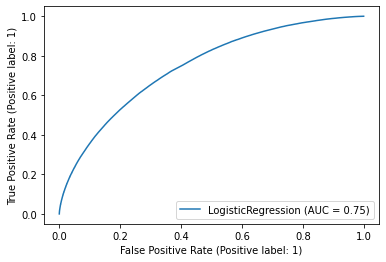

In [23]:
metrics.plot_roc_curve(clf, x_test, y_test) 

In [31]:
print(metrics.classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98   3435681
           1       0.50      0.01      0.01    111924

    accuracy                           0.97   3547605
   macro avg       0.74      0.50      0.50   3547605
weighted avg       0.95      0.97      0.95   3547605

